In [1]:
# =============================================================================
# 1. SETUP E IMPORTAÇÃO DE BIBLIOTECAS
# =============================================================================
import warnings
warnings.filterwarnings('ignore')

# Manipulação de dados
import pandas as pd
import numpy as np

# Visualização
import matplotlib.pyplot as plt
import seaborn as sns
import shap

# Modelos e pipelines
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

# Validação e métricas
from sklearn.model_selection import cross_validate, GroupKFold, GroupShuffleSplit
from sklearn.metrics import make_scorer, r2_score, mean_squared_error

# =============================================================================
# 2. DEFINIÇÃO DOS CONJUNTOS DE FEATURES
# =============================================================================
TARGET = 'interna'
FEATURE_SETS = {
    'simple': ['km', 'ibutg', 'pele', 'fc'],
    'simple_com_velocidade': ['km', 'ibutg', 'pele', 'fc', 'velocidade'],
    'ambiental_completo': ['km', 'ibutg', 'umidade_absoluta', 'umidade_relativa',
                           'ambiente_seca', 'ambiente_umida', 'pele', 'fc']
}

In [4]:
# =============================================================================
# 3. CARREGAMENTO DOS DADOS
# =============================================================================
df = pd.read_csv('/home/leticia-gontijo/Documents/projeto1-doc/tcore/data/dados-organizados-1-1km.csv')
X = df.drop(columns=[TARGET, 'trial_id'])
y = df[TARGET]
groups = df['trial_id']

In [5]:
### NOVO PASSO: DIVISÃO PRIMÁRIA EM TREINO E TESTE (HOLD-OUT) ###
# =============================================================================
# 4. DIVISÃO DOS DADOS EM TREINO E TESTE FINAL (HOLD-OUT)
# =============================================================================
# Usamos GroupShuffleSplit para garantir que os grupos (trial_id) não se misturem
# n_splits=1 para fazer uma única divisão, test_size=0.2 para 80/20
splitter = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(splitter.split(X, y, groups))

# Separando os dados de treino e teste
X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
groups_train = groups.iloc[train_idx]
groups_test = groups.iloc[test_idx] # Não será usado no CV, mas é bom ter

print("--- Divisão Padrão-Ouro Aplicada ---")
print(f"Dataset completo: {len(X)} amostras")
print(f"Conjunto de Treino/Validação: {len(X_train)} amostras")
print(f"Conjunto de Teste Final (Hold-out): {len(X_test)} amostras")

--- Divisão Padrão-Ouro Aplicada ---
Dataset completo: 750 amostras
Conjunto de Treino/Validação: 600 amostras
Conjunto de Teste Final (Hold-out): 150 amostras


In [6]:
# =============================================================================
# 5. DEFINIÇÃO DOS HIPERPARÂMETROS OTIMIZADOS
# =============================================================================
OPTIMIZED_PARAMS = {
    'Lasso': {
        'simple': {'alpha': 0.02868}, 'simple_com_velocidade': {'alpha': 0.02394}, 'ambiental_completo': {'alpha': 0.02631}
    },
    'DecisionTree': {
        'simple': {'max_depth': 10, 'min_samples_leaf': 25, 'min_samples_split': 5},
        'simple_com_velocidade': {'max_depth': 10, 'min_samples_leaf': 25, 'min_samples_split': 5},
        'ambiental_completo': {'max_depth': 10, 'min_samples_leaf': 25, 'min_samples_split': 5}
    },
    'RandomForest': {
        'simple': {'max_features': 0.8, 'max_samples': 0.8, 'min_samples_leaf': 10, 'min_samples_split': 30, 'n_estimators': 200},
        'simple_com_velocidade': {'max_features': 0.7, 'max_samples': 0.8, 'min_samples_leaf': 10, 'min_samples_split': 30, 'n_estimators': 200},
        'ambiental_completo': {'max_features': 0.7, 'max_samples': 0.8, 'min_samples_leaf': 10, 'min_samples_split': 30, 'n_estimators': 400}
    },
    'XGBoost': {
        'simple': {'colsample_bytree': 0.5, 'gamma': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 700, 'reg_alpha': 0.1, 'reg_lambda': 6, 'subsample': 0.5},
        'simple_com_velocidade': {'colsample_bytree': 0.5, 'gamma': 1.0, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 500, 'reg_alpha': 0.1, 'reg_lambda': 8, 'subsample': 0.5},
        'ambiental_completo': {'colsample_bytree': 0.5, 'gamma': 1.0, 'learning_rate': 0.02, 'max_depth': 3, 'n_estimators': 700, 'reg_alpha': 0.1, 'reg_lambda': 8, 'subsample': 0.5}
    }
}

In [7]:
### MODIFICAÇÃO: CV APLICADO APENAS NO CONJUNTO DE TREINO ###
# =============================================================================
# 6. EXECUÇÃO DA VALIDAÇÃO CRUZADA (APENAS NOS DADOS DE TREINO)
# =============================================================================
resultados_validacao = []
cv_splitter = GroupKFold(n_splits=5)
scoring = {
    'r2': 'r2',
    'rmse': make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)), greater_is_better=False)
}

print("\\n--- Iniciando a Validação Cruzada nos dados de TREINO ---")

for feature_set_name, feature_list in FEATURE_SETS.items():
    print(f"\\n>>> Validando com o conjunto de features: '{feature_set_name}'")
    # MODIFICAÇÃO: Usa o subconjunto de X_train
    X_train_subset = X_train[feature_list]

    # Avaliação do Lasso (sempre escalonado)
    print("    - Validando: Lasso_Scaled")
    lasso_params = OPTIMIZED_PARAMS['Lasso'][feature_set_name]
    pipeline_lasso = Pipeline([
        ('scaler', StandardScaler()),
        ('model', Lasso(random_state=42, max_iter=20000, **lasso_params))
    ])
    # MODIFICAÇÃO: Passa X_train_subset, y_train, e groups_train
    scores = cross_validate(pipeline_lasso, X_train_subset, y_train, cv=cv_splitter, scoring=scoring, groups=groups_train, return_train_score=True)
    resultados_validacao.append({
        'model': 'Lasso', 'feature_set': feature_set_name, 'scaled': True,
        'R2_treino_cv': np.mean(scores['train_r2']), 'R2_valid': np.mean(scores['test_r2']),
        'RMSE_treino_cv': -np.mean(scores['train_rmse']), 'RMSE_valid': -np.mean(scores['test_rmse'])
    })

    # Avaliação dos modelos de árvore
    for model_name in ['DecisionTree', 'RandomForest', 'XGBoost']:
        print(f"    - Validando: {model_name}_Unscaled")
        params = OPTIMIZED_PARAMS[model_name][feature_set_name]
        if model_name == 'DecisionTree':
            model_instance = DecisionTreeRegressor(random_state=42, **params)
        elif model_name == 'RandomForest':
            model_instance = RandomForestRegressor(random_state=42, **params)
        elif model_name == 'XGBoost':
            model_instance = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, **params)
        
        # MODIFICAÇÃO: Passa X_train_subset, y_train, e groups_train
        scores_unscaled = cross_validate(model_instance, X_train_subset, y_train, cv=cv_splitter, scoring=scoring, groups=groups_train, return_train_score=True)
        resultados_validacao.append({
            'model': model_name, 'feature_set': feature_set_name, 'scaled': False,
            'R2_treino_cv': np.mean(scores_unscaled['train_r2']), 'R2_valid': np.mean(scores_unscaled['test_r2']),
            'RMSE_treino_cv': -np.mean(scores_unscaled['train_rmse']), 'RMSE_valid': -np.mean(scores_unscaled['test_rmse'])
        })

print("\\n--- Validação Cruzada concluída ---")
results_df_valid = pd.DataFrame(resultados_validacao)
display(results_df_valid)

\n--- Iniciando a Validação Cruzada nos dados de TREINO ---
\n>>> Validando com o conjunto de features: 'simple'
    - Validando: Lasso_Scaled
    - Validando: DecisionTree_Unscaled
    - Validando: RandomForest_Unscaled
    - Validando: XGBoost_Unscaled
\n>>> Validando com o conjunto de features: 'simple_com_velocidade'
    - Validando: Lasso_Scaled
    - Validando: DecisionTree_Unscaled
    - Validando: RandomForest_Unscaled
    - Validando: XGBoost_Unscaled
\n>>> Validando com o conjunto de features: 'ambiental_completo'
    - Validando: Lasso_Scaled
    - Validando: DecisionTree_Unscaled
    - Validando: RandomForest_Unscaled
    - Validando: XGBoost_Unscaled
\n--- Validação Cruzada concluída ---


,model,feature_set,scaled,R2_treino_cv,R2_valid,RMSE_treino_cv,RMSE_valid
0,Lasso,simple,True,0.798170,0.783220,0.421695,0.434207
1,DecisionTree,simple,False,0.795424,0.732597,0.424528,0.481265
2,RandomForest,simple,False,0.835850,0.783970,0.380306,0.433407
3,XGBoost,simple,False,0.854617,0.778077,0.357950,0.439218
4,Lasso,simple_com_velocidade,True,0.804683,0.780946,0.414806,0.436110
5,DecisionTree,simple_com_velocidade,False,0.795465,0.729607,0.424491,0.484084
6,RandomForest,simple_com_velocidade,False,0.840554,0.782822,0.374803,0.434477
7,XGBoost,simple_com_velocidade,False,0.853632,0.774651,0.359123,0.442145
8,Lasso,ambiental_completo,True,0.801414,0.781322,0.418272,0.435747
9,DecisionTree,ambiental_completo,False,0.796634,0.728386,0.423287,0.485315


In [8]:
### NOVO PASSO: AVALIAÇÃO FINAL DO MELHOR MODELO NO CONJUNTO DE TESTE ###
# =============================================================================
# 7. SELEÇÃO E AVALIAÇÃO FINAL NO CONJUNTO DE TESTE (HOLD-OUT)
# =============================================================================

# Seleciona o melhor experimento com base no menor RMSE de VALIDAÇÃO
best_experiment = results_df_valid.sort_values('RMSE_valid').iloc[0]
best_model_name = best_experiment['model']
best_feature_set_name = best_experiment['feature_set']
best_params = OPTIMIZED_PARAMS[best_model_name][best_feature_set_name]
best_was_scaled = best_experiment['scaled']

print(f"--- Melhor modelo (da validação): {best_experiment['model']} ({best_experiment['feature_set']}) ---")
print(f"  - RMSE de Validação (média do CV): {best_experiment['RMSE_valid']:.4f}")

# Subconjuntos de features para o melhor modelo
best_features = FEATURE_SETS[best_feature_set_name]
X_train_best = X_train[best_features]
X_test_best = X_test[best_features]

# Instancia o pipeline final do melhor modelo
if best_model_name == 'Lasso':
    final_model_instance = Lasso(random_state=42, max_iter=20000, **best_params)
elif best_model_name == 'DecisionTree':
    final_model_instance = DecisionTreeRegressor(random_state=42, **best_params)
elif best_model_name == 'RandomForest':
    final_model_instance = RandomForestRegressor(random_state=42, **best_params)
elif best_model_name == 'XGBoost':
    final_model_instance = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, **best_params)

# Define o pipeline (com ou sem scaler)
if best_was_scaled:
    final_pipeline = Pipeline([('scaler', StandardScaler()), ('model', final_model_instance)])
else:
    final_pipeline = Pipeline([('model', final_model_instance)])

# Treina o modelo final com TODOS os dados de TREINO
final_pipeline.fit(X_train_best, y_train)

# Faz predições no conjunto de TESTE (hold-out)
y_pred_final = final_pipeline.predict(X_test_best)

# Calcula as métricas finais
r2_final = r2_score(y_test, y_pred_final)
rmse_final = np.sqrt(mean_squared_error(y_test, y_pred_final))

print("\\n--- Resultado Final no Conjunto de Teste (Hold-out) ---")
print(f"  - R² Teste Final: {r2_final:.4f}")
print(f"  - RMSE Teste Final: {rmse_final:.4f}")

--- Melhor modelo (da validação): XGBoost (ambiental_completo) ---
  - RMSE de Validação (média do CV): 0.4290
\n--- Resultado Final no Conjunto de Teste (Hold-out) ---
  - R² Teste Final: 0.8487
  - RMSE Teste Final: 0.3961


\n--- Análise de Interpretabilidade com SHAP no Melhor Modelo ---
Calculando os valores SHAP...
Gerando gráficos SHAP...


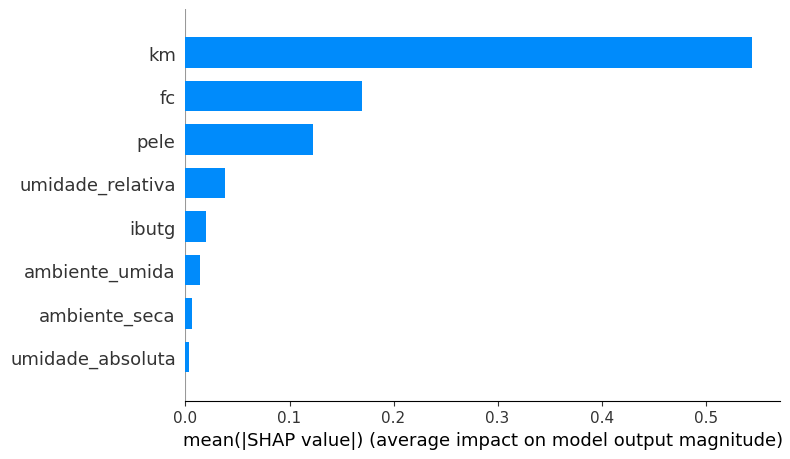

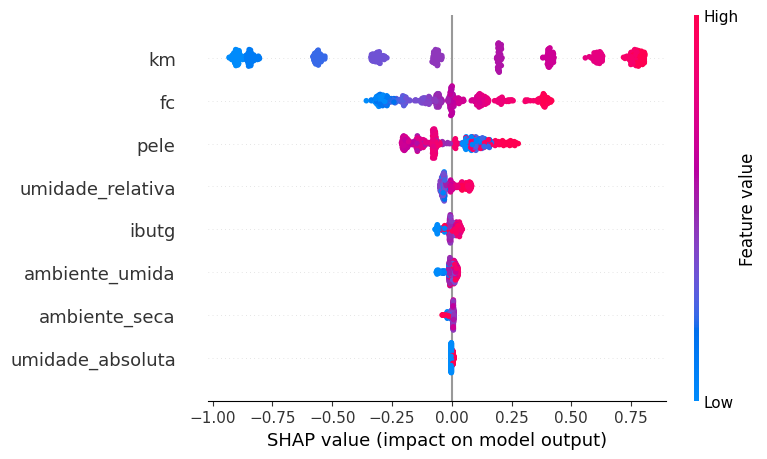

In [9]:
### MODIFICAÇÃO: ANÁLISE SHAP NO MODELO TREINADO NOS DADOS DE TREINO ###
# =============================================================================
# 8. ANÁLISE DE INTERPRETABILIDADE (SHAP)
# =============================================================================
print("\\n--- Análise de Interpretabilidade com SHAP no Melhor Modelo ---")

# Prepara dados para SHAP usando o conjunto de treino
X_shap = X_train_best
if best_was_scaled:
    X_shap = pd.DataFrame(final_pipeline.named_steps['scaler'].transform(X_train_best), columns=best_features)

# Explainer SHAP (o final_pipeline já foi treinado na célula anterior)
model_fitted = final_pipeline.named_steps['model']
explainer = None
if best_model_name in ['DecisionTree', 'RandomForest', 'XGBoost']:
    explainer = shap.TreeExplainer(model_fitted)
elif best_model_name == 'Lasso':
    explainer = shap.LinearExplainer(model_fitted, X_shap)

if explainer:
    print("Calculando os valores SHAP...")
    shap_values = explainer.shap_values(X_shap)
    print("Gerando gráficos SHAP...")
    
    shap.summary_plot(shap_values, X_shap, plot_type="bar", show=True)
    shap.summary_plot(shap_values, X_shap, show=True)
else:
    print(f"Análise SHAP não implementada para o tipo de modelo: {best_model_name}")